## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
# ref: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html#calibration

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# calibration images has 9x6 inner corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(nx,ny,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## 2. UnDistort Images

Should now have objpoints and imgpoints needed for camera calibration. Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb

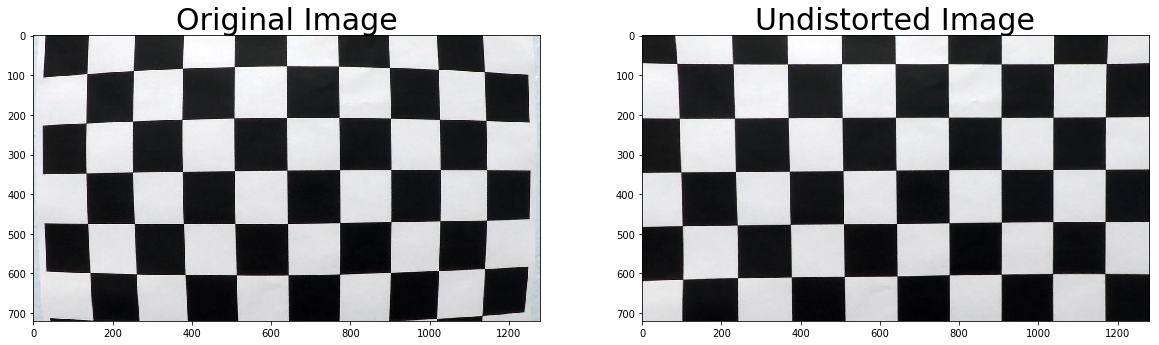

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_cal/calibration_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [3]:
import numpy as np
import cv2

def abs_sobel_thresh(img, orient='x', ksize=3, thresh_min=0, thresh_max=255):
    """Absolute Sobel Gradient Thresholded
    
    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        thresh_min (int)
        thresh_max (int)
    """
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
        
    # 3) Take the absolute value of the gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """Magnitude of Sobel in x and y directions and thresholded
    
    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        sobel_kernel (int)
        mag_thresh (tuple) : (min, max) 2 element tuple 
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobel_mag = np.sqrt( sobel_x**2 + sobel_y**2 )
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Direction of Sobel gradient in x and y combined then thresholded
    
    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        sobel_kernel (int)
        thresh (tuple) : (min, max) 2 element tuple, default 0 to 90 degrees
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    gradient = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like( gradient )
    
    # 6) Return this mask as your binary_output image
    binary_output[(gradient >= thresh[0]) & (gradient <= thresh[1])] = 1

    return binary_output


In [4]:
def colorAndGradientThresholdBinary(img, color_thresh=(170, 255), sobel_thresh=(20, 100), ksize=3):
    """Use Sobel gradient and Color transforms to create a thresholded binary image

    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        color_thresh (tuple): Color channel threshold. Two element tuple.
        sobel_thresh (tuple): Sobel operator threshold. Two element tuple.
        ksize (int): Sobel operator kernel size.

    Returns:
        (color_binary, sx_binary, s_binary): color_binary, sx_binary, s_binary
    """
    img = np.copy(img)
    
    ### Sobel Gradient in x direction ( x direction accentuates vertical lines )
    #sx_binary = abs_sobel_thresh(img, orient='x', ksize=3, thresh_min=sobel_thresh[0], thresh_max=sobel_thresh[1])
    
    ### Sobel magnitude
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100)) # (30,100) seems to work well
    
    ### Sobel direction (0.5 to 1.4) is about (30 to 80 degrees)
    dir_binary = dir_threshold(image, sobel_kernel=13, thresh=(0.5, 1.4))
    
    ### Combine magnitude and direction where both thresholds are satisfied
    # (note that magnitude and direction takes both individual Sobel x and y into account)
    sobel_combined_binary = np.zeros_like(dir_binary)
    sobel_combined_binary[((mag_binary == 1) & (dir_binary == 1))] = 1

    ### Color Channel
    # Convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresh[0]) & (s_channel <= color_thresh[1])] = 1
    
    s_gradiented_binary = ((s_binary == 1) & (dir_binary == 1)) # s_binary filtered by gradient
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= 15) & (h_channel <= 30)] = 1
    
    color_combined_binary = np.zeros_like(s_binary)
    color_combined_binary[ (s_binary == 1) & ( h_binary == 1)] =1

    color_gradiented_binary = ((color_combined_binary == 1) & (dir_binary == 1)) # s_binary filtered by gradient
        
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sobel_combined_binary), sobel_combined_binary, color_gradiented_binary))
    
    # Combine sobel and color results
    combined_binary = np.zeros_like(sobel_combined_binary)
    combined_binary[ (sobel_combined_binary == 1) | (color_gradiented_binary == 1) ] = 1
    
    return combined_binary, color_binary, \
        sobel_combined_binary, mag_binary, dir_binary, \
        s_gradiented_binary, s_binary, h_binary, color_gradiented_binary
    

type(image)=<class 'numpy.ndarray'>, image.shape=(720, 1280, 3)
type(color_binary)=<class 'numpy.ndarray'>, color_binary.shape=(720, 1280, 3)
type(sobel_binary)=<class 'numpy.ndarray'>, sobel_binary.shape=(720, 1280)
color_binary[360][0:10]=[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


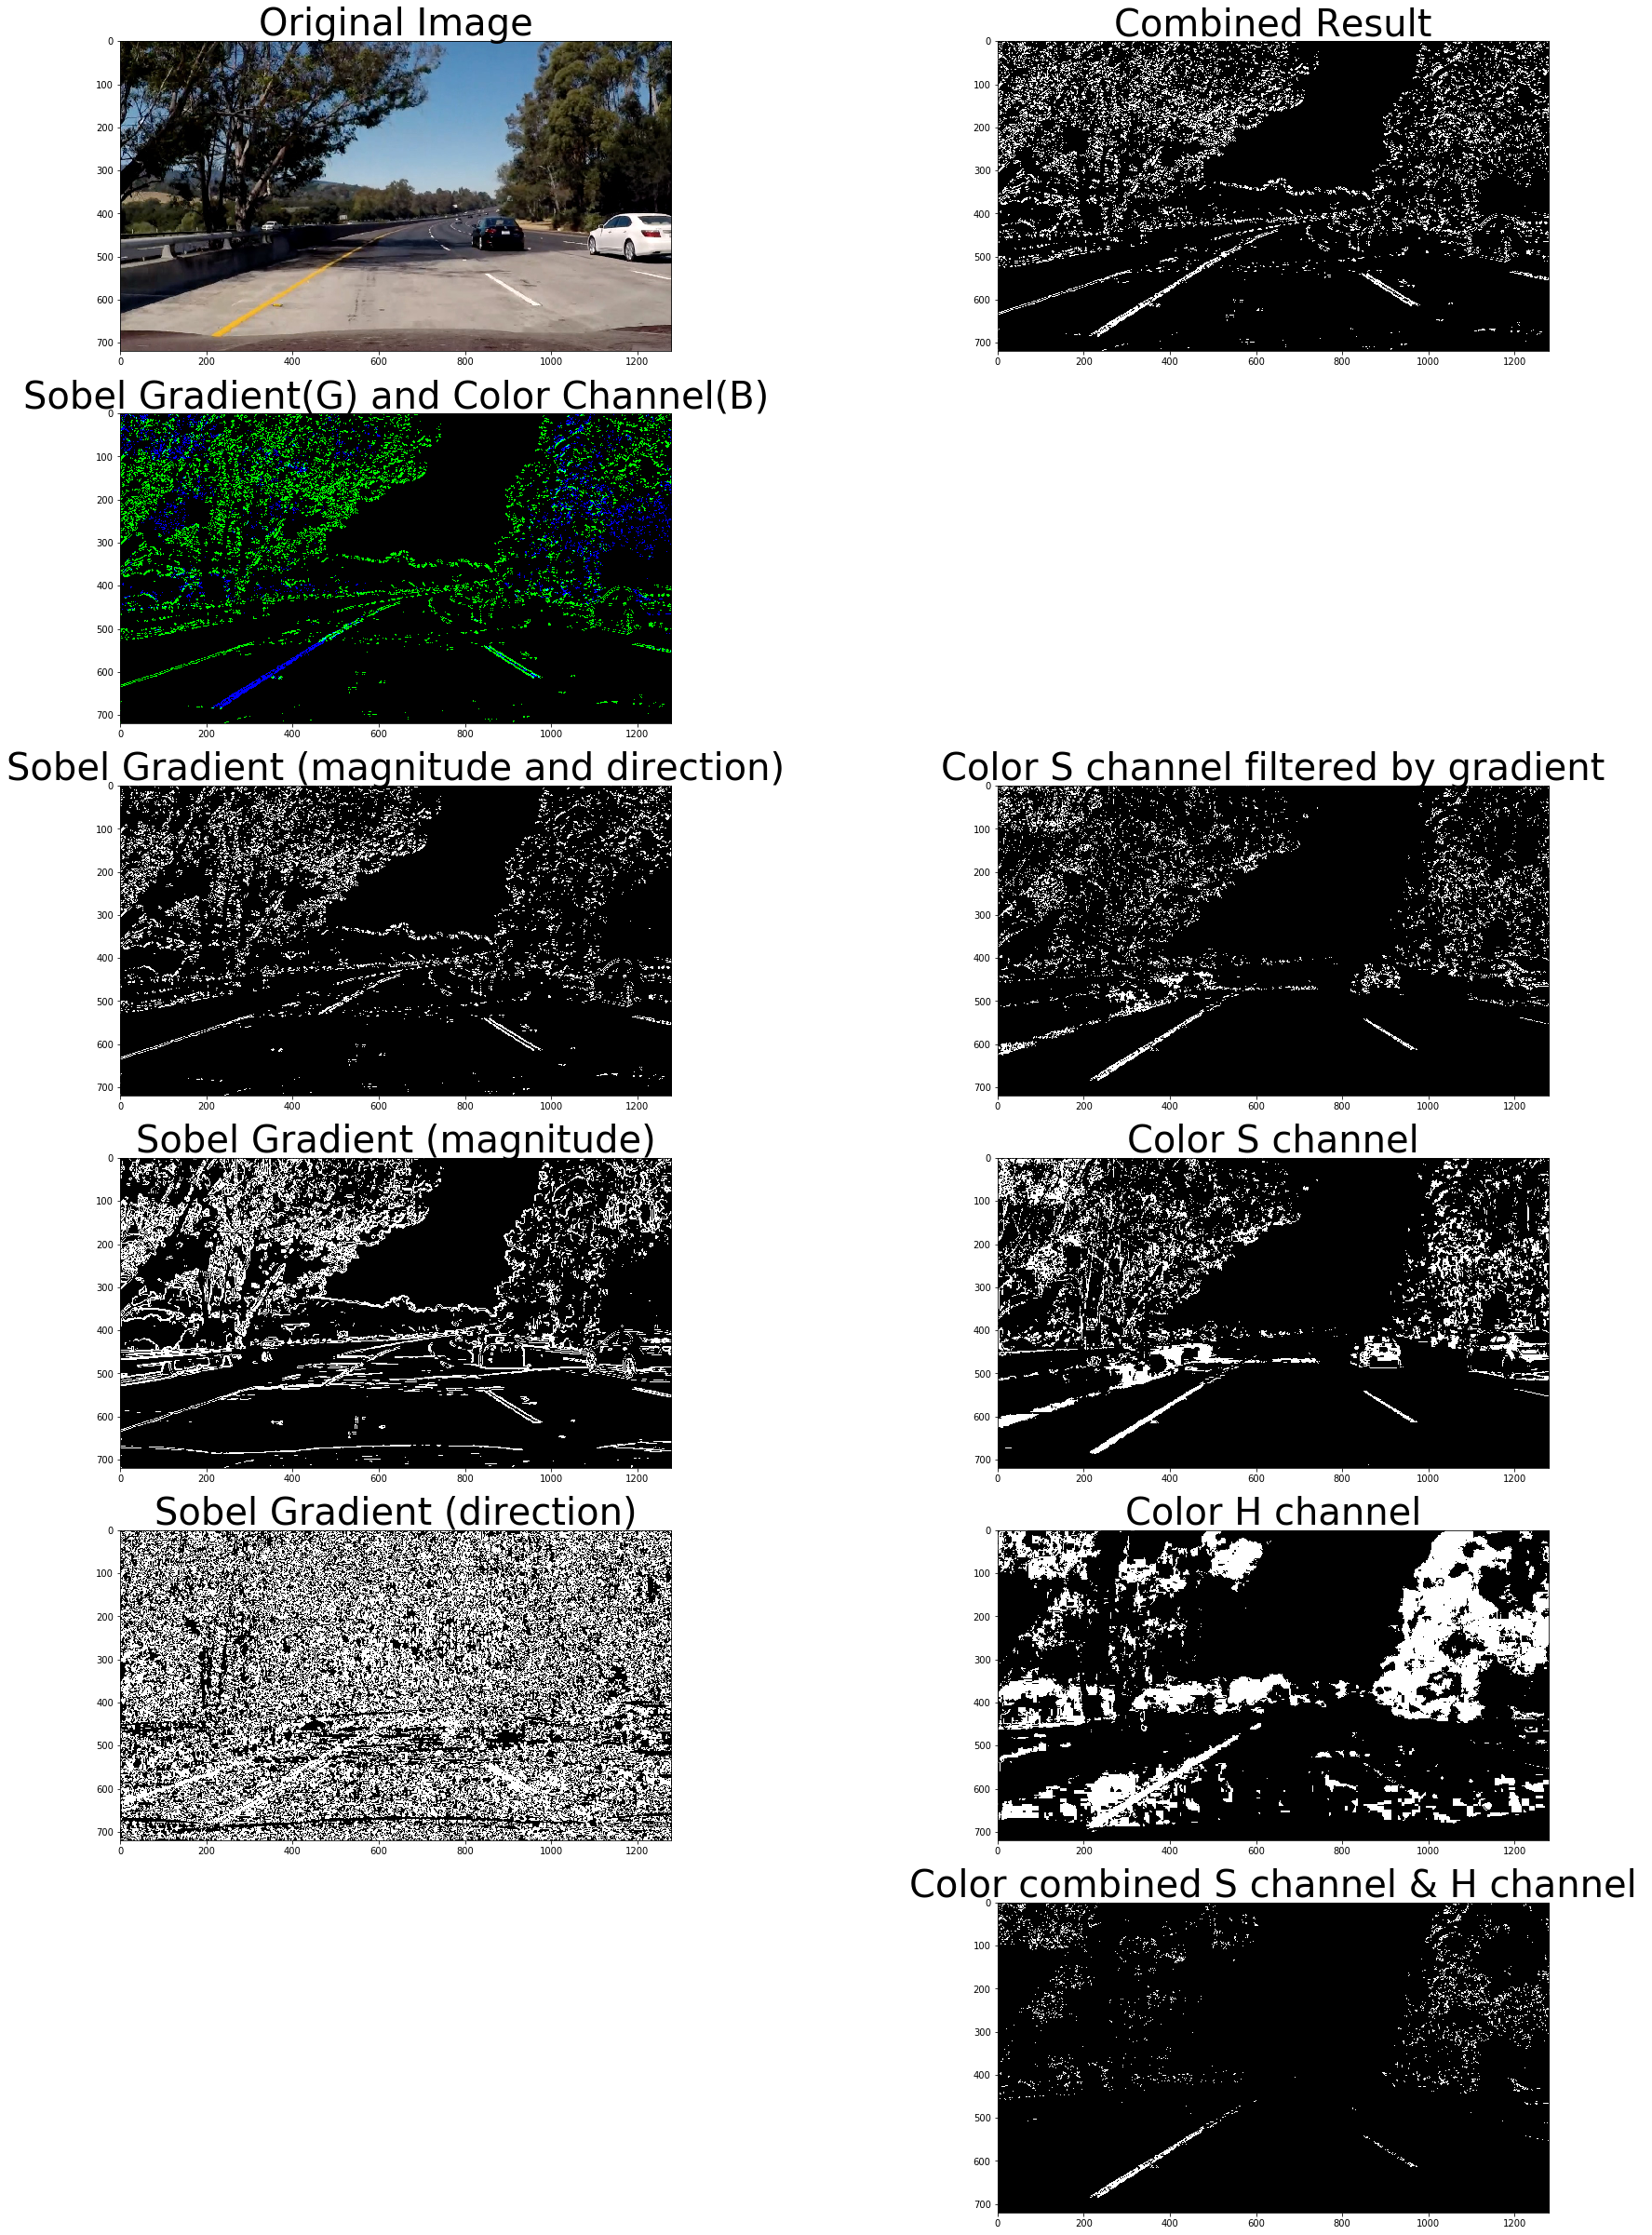

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# NOTE jpg and png format pixel values are different ranges? jpg = 8bit?
# image = mpimg.imread('./signs_vehicles_xygrad.png') 
image = mpimg.imread('./test_images/test5.jpg')

print("type(image)={}, image.shape={}".format( type(image), image.shape ))

result, color_binary, sobel_binary, mag_binary, dir_binary, s_gradiented_binary, s_binary, h_binary, color_combined_binary = \
    colorAndGradientThresholdBinary(image, color_thresh=(128, 255), sobel_thresh=(20, 100), ksize=5)

print("type(color_binary)={}, color_binary.shape={}".format( type(color_binary), color_binary.shape ))
print("type(sobel_binary)={}, sobel_binary.shape={}".format( type(sobel_binary), sobel_binary.shape ))
print("color_binary[360][0:10]={}".format( color_binary[360][0:10] ))
# Plot the result
f, axes = plt.subplots(6, 2, squeeze=False, figsize=(24, 36))
# f.tight_layout()

axes[0][0].imshow(image)
axes[0][0].set_title('Original Image', fontsize=40)

axes[0][1].imshow(result, cmap='gray')
axes[0][1].set_title('Combined Result', fontsize=40)

axes[1][0].imshow(color_binary)
axes[1][0].set_title('Sobel Gradient(G) and Color Channel(B)', fontsize=40)

axes[1][1].axis('off')

axes[2][0].imshow(sobel_binary, cmap='gray')
axes[2][0].set_title('Sobel Gradient (magnitude and direction)', fontsize=40)

axes[3][0].imshow(mag_binary, cmap='gray')
axes[3][0].set_title('Sobel Gradient (magnitude)', fontsize=40)

axes[4][0].imshow(dir_binary, cmap='gray')
axes[4][0].set_title('Sobel Gradient (direction)', fontsize=40)

axes[2][1].imshow(s_gradiented_binary, cmap='gray')
axes[2][1].set_title('Color S channel filtered by gradient', fontsize=40)

axes[3][1].imshow(s_binary, cmap='gray')
axes[3][1].set_title('Color S channel', fontsize=40)

axes[4][1].imshow(h_binary, cmap='gray')
axes[4][1].set_title('Color H channel', fontsize=40)

axes[5][0].axis('off')

axes[5][1].imshow(color_combined_binary, cmap='gray')
axes[5][1].set_title('Color combined S channel & H channel', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Gradient Usage
'And'ing gradient direction to magnitude helps to filter out horizontal lines (like the hood).

### Color Channel Usage
The H channel results in a noisy binary.  
S channel picks up lane lines well but also other features as well,
for example, it picks up the concrete barrier under the tree in image "test_images/test5.jpg".  

The S channel binary can be cleaned up by filtering ('and'ing) with the sobel gradient direction.

Combining S and H channel binaries by 'AND'ing removes noise such as the cars in image "test_images/test5.jpg".
Combining the combine S and H channel result by 'AND'ing with the Sobel gradient direciton further reduces noise.


## Image UnDistort

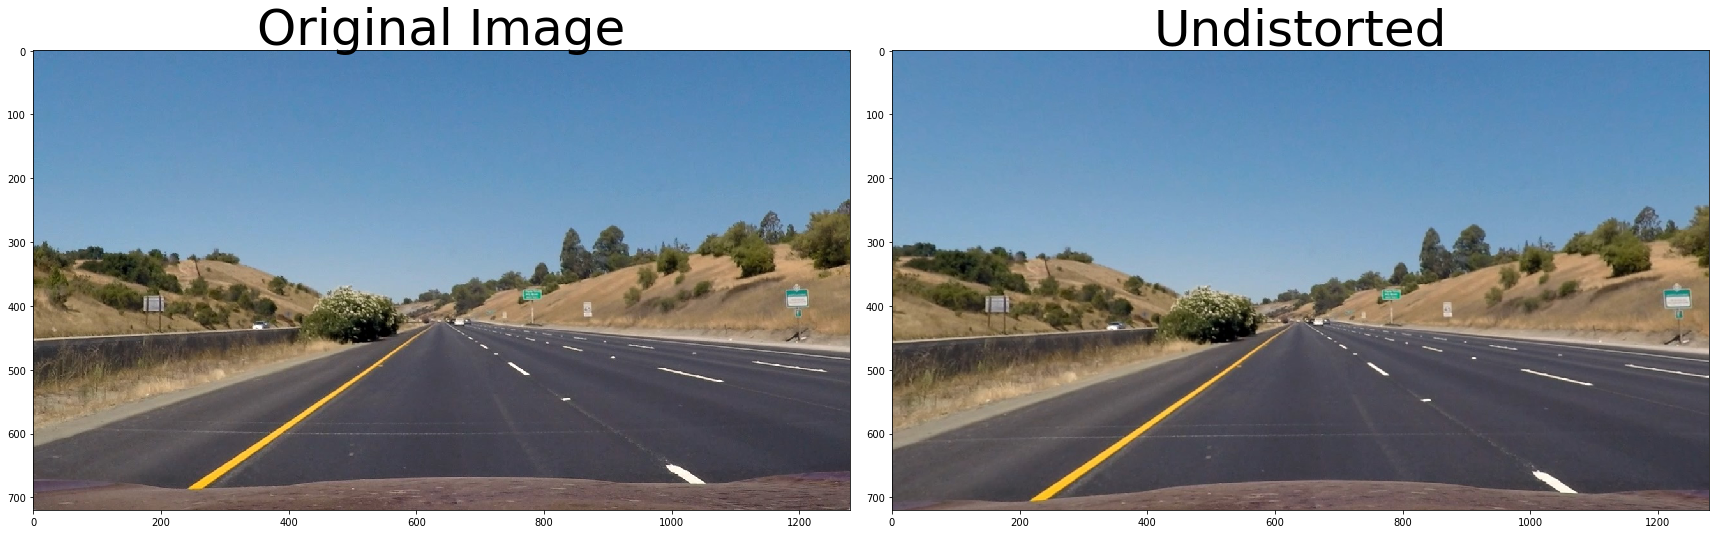

In [6]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# Read in the saved camera matrix and distortion coefficients
# These are the arrays calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/calibration_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img_orig = mpimg.imread('test_images/straight_lines1.jpg')

# 1) Undistort using mtx and dist
img = cv2.undistort(img_orig, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_orig)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img)
ax2.set_title('Undistorted', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

In [7]:
import cv2
import numpy as np

def image_warp(img, mtx, dist, src, dst):
    """Warp image using perspective transform
    
    First, undistort image using camera calibration
    
    Args:
        img (numpy.ndarray): Source image. Color channels in RGB order.
        mtx: camera matrix, 
        dist: distortion coefficients
        src (numpy.ndarray): source points
        dst (numpy.ndarray): destination points
        
    Returns:
        (warped, M): warped image, transform matrix
    """
        
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    img_size = (img.shape[1], img.shape[0]) # note switch of x,y order

    # 3) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M

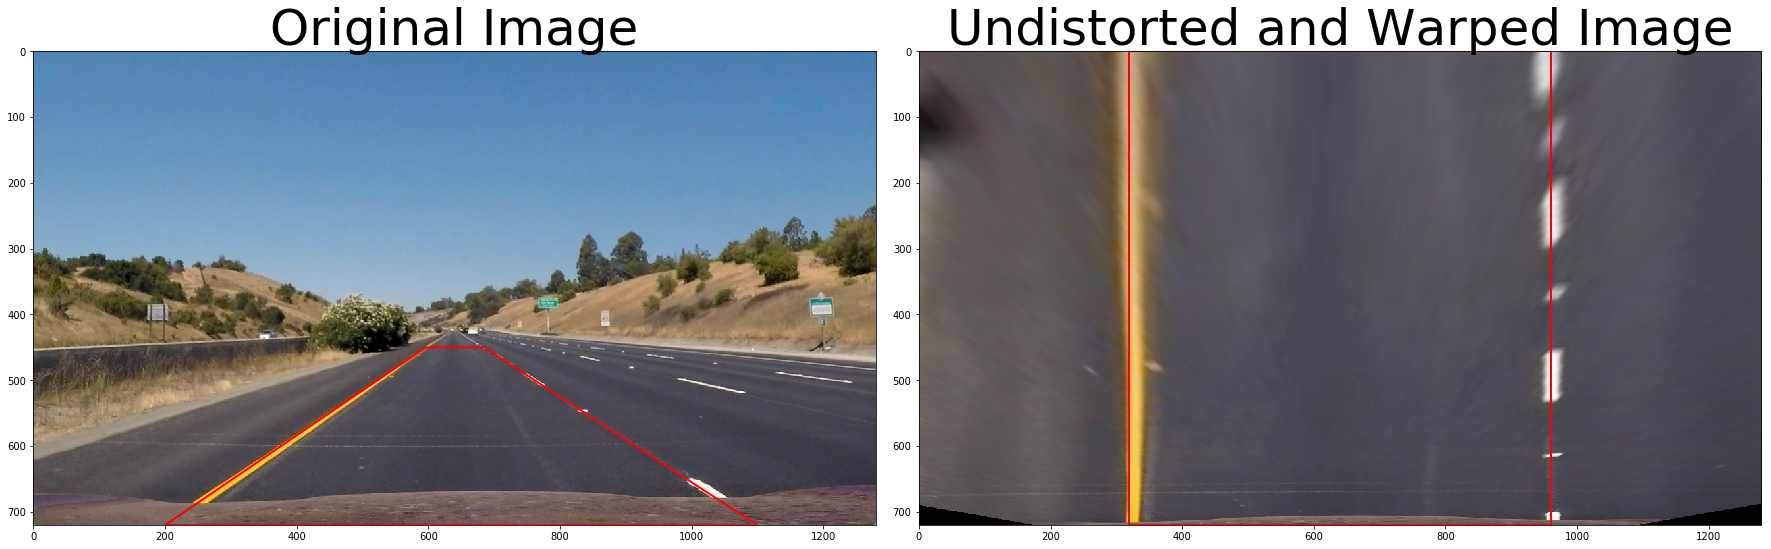

In [8]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.path import Path
import matplotlib.patches as patches

# Read in the saved camera matrix and distortion coefficients
# These are the arrays calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/calibration_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = mpimg.imread('test_images/straight_lines1.jpg')

# Define 4 source points 
# top left [622,435]
# top right [662,435]
# bottom right [1040,675]
# bottom left [272,675]
src_points = [[596,450],[685,450],[1100,720],[200,720]]
src = np.float32(src_points)

# Define 4 destination points
dst_points = [
    [320, 0], 
    [960, 0], 
    [960, 720], 
    [320, 720]]
dst = np.float32(dst_points)

# warp image
img_warped, M = image_warp(img, mtx, dist, src, dst)

# display result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)

# draw the src points boundary
verts = np.float32( src_points + [src_points[0]] )
codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(verts, codes)
patch = patches.PathPatch(path, edgecolor='red', facecolor='none', lw=2)
ax1.add_patch(patch)

ax1.set_title('Original Image', fontsize=50)

ax2.imshow( img_warped )

# draw the dst points boundary
verts = np.float32( dst_points + [dst_points[0]] )

path = Path(verts, codes)
patch = patches.PathPatch(path, edgecolor='red', facecolor='none', lw=2)
ax2.add_patch(patch)

ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
